# Boston Marathon
----

In [203]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering
%matplotlib inline

In [90]:
# https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2010/results.csv

data_path = ("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv")
df = pd.read_csv(data_path)

In [91]:
print(df.shape)
df.head()

(16164, 21)


,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [92]:
nans = lambda df: df[df.isnull().any(axis=1)]
len(nans(df))

15581

In [93]:
# Converting to categorical
convert_cat = []
to_drop = []
unique = None

categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    unique = column.nunique()
    print(unique)
    

25k
3245
name
16137
10k
1459
gender
2
half
2761
bib
16157
ctz
75
country
68
state
65
30k
3862
5k
808
20k
2644
35k
4539
city
4416
40k
5136


In [94]:
# Clean strings
df['25k'] = df['25k'].str.replace('-','')
df['10k'] = df['10k'].str.replace('-','')
df['30k'] = df['30k'].str.replace('-','')
df['5k'] = df['5k'].str.replace('-','')
df['20k'] = df['20k'].str.replace('-','')
df['35k'] = df['35k'].str.replace('-','')
df['40k'] = df['40k'].str.replace('-','')
df['half'] = df['half'].str.replace('-','')

In [95]:
# convert to numeric
df['25k'] = pd.to_numeric(df['25k'])
df['10k'] = pd.to_numeric(df['10k'])
df['30k'] = pd.to_numeric(df['30k'])
df['5k'] = pd.to_numeric(df['5k'])
df['20k'] = pd.to_numeric(df['20k'])
df['35k'] = pd.to_numeric(df['35k'])
df['40k'] = pd.to_numeric(df['40k'])
df['half'] = pd.to_numeric(df['half'])

In [96]:
# Converting to categorical
convert_cat = []
to_drop = []
unique = None

categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    unique = column.nunique()
    print(unique)

name
16137
gender
2
bib
16157
ctz
75
country
68
state
65
city
4416


In [97]:
df['ctz'].isnull().sum()

15407

In [99]:
# Drop because it is mainly NaN
df = df.loc[:, ~df.columns.isin(['ctz'])]

# Drop because many unique values
df = df.loc[:, ~df.columns.isin(['name', 'bib'])]

In [100]:
df = pd.get_dummies(data=df, columns=['country', 'state', 'city', 'gender'])

In [80]:
df.head()

,25k,age,division,10k,half,official,overall,pace,30k,5k,...,city_Zion Grove,city_Zionsville,city_Zornheim,city_Zuckenriet,city_Zuerich,city_Zug,city_Zurich,city_boston,gender_F,gender_M
0,49.87,28,9,18.18,40.93,90.90,9,3.47,62.07,8.90,...,0,0,0,0,0,0,0,0,0,1
1,77.27,30,5,30.90,64.90,132.50,5,5.07,92.97,15.90,...,0,0,0,0,0,0,0,0,0,1
2,77.23,23,1,30.90,64.92,130.37,1,4.98,92.72,15.93,...,0,0,0,0,0,0,0,0,0,1
3,50.50,32,5,18.73,42.00,88.43,5,3.38,61.35,8.98,...,0,0,0,0,0,0,0,0,0,1
4,48.75,39,3,18.18,40.57,87.22,3,3.33,59.92,8.92,...,0,0,0,0,0,0,0,0,0,1


In [102]:
nans = lambda df: df[df.isnull().any(axis=1)]
len(nans(df))

110

In [116]:
nan_features = df.columns[df.isnull().any()].tolist()

In [120]:
nan_features

['25k', '10k', 'half', '30k', '5k', '20k', '35k', '40k']

In [125]:
# For numerical data, impute using mean OR median values
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp = imp.fit(df[nan_features])

# Impute our data
df[nan_features] = imp.transform(df[nan_features])

In [126]:
nans = lambda df: df[df.isnull().any(axis=1)]
len(nans(df))

0

No more NaN values.

In [128]:
# Save the DF for future reference
df.to_csv('./data/df_V1.csv')

In [130]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [131]:
normalized_df.head()

,25k,age,division,10k,half,official,overall,pace,30k,5k,...,city_Zion Grove,city_Zionsville,city_Zornheim,city_Zuckenriet,city_Zuerich,city_Zug,city_Zurich,city_boston,gender_F,gender_M
0,0.013443,0.161290,0.002087,0.003083,0.006707,0.027026,0.000455,0.026385,0.019205,0.001232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.251084,0.193548,0.001044,0.264543,0.250305,0.236387,0.000227,0.237467,0.245712,0.288706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.250737,0.080645,0.000000,0.264543,0.250508,0.225667,0.000000,0.225594,0.243879,0.289938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.018907,0.225806,0.001044,0.014388,0.017581,0.014595,0.000227,0.014512,0.013928,0.004517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.003729,0.338710,0.000522,0.003083,0.003049,0.008505,0.000114,0.007916,0.003445,0.002053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [137]:
normalized_df.shape

(16164, 4565)

## Correlation Matrix

In [138]:
# Run correlation matrix
correlation_matrix = normalized_df.corr()
display(correlation_matrix)

,25k,age,division,10k,half,official,overall,pace,30k,5k,...,city_Zion Grove,city_Zionsville,city_Zornheim,city_Zuckenriet,city_Zuerich,city_Zug,city_Zurich,city_boston,gender_F,gender_M
25k,1.000000,0.380791,0.210448,0.979080,0.996183,0.941201,0.915000,0.941166,0.994140,0.962131,...,0.005091,0.000465,0.000419,0.003898,-0.010471,-0.001072,-0.014622,0.000605,0.473313,-0.473313
age,0.380791,1.000000,-0.490299,0.372693,0.381424,0.369451,0.369993,0.369453,0.378959,0.365822,...,-0.001245,0.007072,0.006354,0.007874,0.001035,0.002555,-0.007860,-0.008084,-0.247642,0.247642
division,0.210448,-0.490299,1.000000,0.172864,0.193533,0.311555,0.291935,0.311527,0.237573,0.162897,...,-0.004208,0.000419,-0.005485,-0.000133,-0.008107,-0.000643,-0.002323,0.019579,0.092628,-0.092628
10k,0.979080,0.372693,0.172864,1.000000,0.988629,0.890815,0.861109,0.890777,0.961352,0.991342,...,0.003844,-0.000183,0.000944,0.002754,-0.010176,-0.003254,-0.013584,0.000711,0.479074,-0.479074
half,0.996183,0.381424,0.193533,0.988629,1.000000,0.923973,0.897242,0.923939,0.985376,0.973121,...,0.004817,0.000143,0.000776,0.003889,-0.010224,-0.001596,-0.014301,0.000649,0.476634,-0.476634
official,0.941201,0.369451,0.311555,0.890815,0.923973,1.000000,0.974097,0.999981,0.964128,0.871338,...,0.004635,0.001698,-0.002183,0.003999,-0.011688,-0.000450,-0.015949,0.006699,0.395501,-0.395501
overall,0.915000,0.369993,0.291935,0.861109,0.897242,0.974097,1.000000,0.974073,0.938624,0.840007,...,0.005357,0.000832,-0.003423,0.004566,-0.011474,-0.001346,-0.017095,0.007798,0.411230,-0.411230
pace,0.941166,0.369453,0.311527,0.890777,0.923939,0.999981,0.974073,1.000000,0.964097,0.871308,...,0.004625,0.001760,-0.002149,0.003931,-0.011702,-0.000412,-0.015957,0.006710,0.395459,-0.395459
30k,0.994140,0.378959,0.237573,0.961352,0.985376,0.964128,0.938624,0.964097,1.000000,0.942868,...,0.005007,0.000749,-0.000405,0.003737,-0.010847,-0.000616,-0.014937,0.005569,0.461528,-0.461528
5k,0.962131,0.365822,0.162897,0.991342,0.973121,0.871338,0.840007,0.871308,0.942868,1.000000,...,0.003273,-0.000414,0.000173,0.003369,-0.010214,-0.004301,-0.014057,0.003529,0.480450,-0.480450


In [139]:
# Correlated features to be dropped
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(f'Number of correlated features to drop: {len(to_drop)}')

cols = list(normalized_df.columns)

for col in to_drop: 
    cols.remove(col)

len(cols)

normalized_df = normalized_df[cols]

Number of correlated features to drop: 23


In [148]:
# Save the DF for future reference
normalized_df.to_csv('./data/normalized_df.csv')

## Variance Threshold

In [149]:
# Removes all low-variance features
def variance_threshold_selector(data, threshold=0.05):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

vt_to_keep = variance_threshold_selector(normalized_df)

vt_to_keep.head()

,division,genderdiv,country_CAN,country_USA,state_CA,state_MA,state_NY,gender_F,gender_M
0,0.002087,0.000751,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.001044,0.000376,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.001044,0.000376,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000522,0.000188,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [150]:
normalized_df = normalized_df[vt_to_keep.columns]

In [151]:
normalized_df.shape

(16164, 9)

### Split up the DataFrame for testing consistency

In [186]:
X_half1, X_half2 = train_test_split(normalized_df, test_size=0.5, random_state=42)

In [192]:
X1, X2 = train_test_split(X_half1, test_size=0.5, random_state=42)
X3, X4 = train_test_split(X_half2, test_size=0.5, random_state=42)

## KMeans

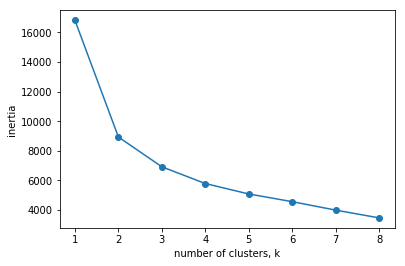

In [153]:
# Intertias
ks = range(1, 9)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(normalized_df)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## silhouette score

In [179]:
model = KMeans(n_clusters=3, random_state=42).fit(normalized_df)
labels = model.labels_
print(metrics.silhouette_score(normalized_df, labels, metric='euclidean'))

0.4600325092811089


In [210]:
kmeans_sil_arr = []

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=3, random_state=42).fit(sample)
    labels = model.labels_
    sil = metrics.silhouette_score(sample, labels, metric='euclidean')
    kmeans_sil_arr.append(sil)
    print(sil)

0.4603707242508296
0.45646241384479563
0.4626390054427816
0.4605335637237413


In [211]:
np.var(kmeans_sil_arr)

4.975246026689996e-06

Results are consistent

## Mean Shift

In [200]:
bandwidth = estimate_bandwidth(normalized_df)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(normalized_df)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 3


In [201]:
print(metrics.silhouette_score(normalized_df, labels, metric='euclidean'))

0.45299633427635244


In [213]:
ms_sil_arr = []

for sample in [X1, X2, X3, X4]:
    bandwidth = estimate_bandwidth(sample)

    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(sample)

    # Extract cluster assignments for each data point.
    labels = ms.labels_

    # Coordinates of the cluster centers.
    cluster_centers = ms.cluster_centers_

    # Count our clusters.
    n_clusters_ = len(np.unique(labels))

    print("Number of estimated clusters: {}".format(n_clusters_))
    sil = metrics.silhouette_score(sample, labels, metric='euclidean')
    ms_sil_arr.append(sil)
    print(sil)
    print('------\n')

Number of estimated clusters: 3
0.45411466573289466
------

Number of estimated clusters: 3
0.4482132218901229
------

Number of estimated clusters: 3
0.4528404074212413
------

Number of estimated clusters: 3
0.45672814418753616
------



In [214]:
np.var(ms_sil_arr)

9.519393008841176e-06

## Spectral

In [215]:
sp_sil_arr = []

for sample in [X1, X2, X3, X4]:
    
    # We know we're looking for three clusters.
    n_clusters=3

    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n_clusters)
    sc.fit(sample)
    
    labels = sc.labels_

    # Count our clusters.
    n_clusters_ = len(np.unique(labels))

    print("Number of estimated clusters: {}".format(n_clusters_))
    sil = metrics.silhouette_score(sample, labels, metric='euclidean')
    sp_sil_arr.append(sil)
    print(sil)
    print('------\n')

Number of estimated clusters: 3
0.4802194400223594
------

Number of estimated clusters: 3
0.47716448834042413
------

Number of estimated clusters: 3
0.4825699524908891
------

Number of estimated clusters: 3
0.481618778569209
------



In [216]:
np.var(sp_sil_arr)

4.17376643536662e-06

In [ ]:
# Create X1 -> 4 and then run the silhloutte score for all
# try mean shift and other clustering algorithms and see how they compare with their silhloutte